# Tabular models

In [1]:
from fastai.tabular import *
from datetime import datetime, timedelta
from tqdm import tqdm

Tabular data should be in a Pandas `DataFrame`.

In [2]:
path = Path('../../data/retail_dataset/walmart/')
df_feature = pd.read_csv(path/'features.csv')
df_sales = pd.read_csv(path/'train.csv')
df_stores = pd.read_csv(path/'stores.csv')
df_test = pd.read_csv(path/'test.csv')

Joining all data together, and removing rows with missing value in the target column (Weekly_Sales). 

This happens because some of the stores data are in the test set and not in the training set.

In [3]:
df_temp = df_sales.join(df_stores.set_index('Store'), on='Store')
df = df_temp.join(df_feature.set_index(['Store','Date']), on=['Store','Date'], how='left', lsuffix='_original')

In [4]:
df.isnull().sum()

Store                      0
Dept                       0
Date                       0
Weekly_Sales               0
IsHoliday_original         0
Type                       0
Size                       0
Temperature                0
Fuel_Price                 0
MarkDown1             270889
MarkDown2             310322
MarkDown3             284479
MarkDown4             286603
MarkDown5             270138
CPI                        0
Unemployment               0
IsHoliday                  0
dtype: int64

In [5]:
# Let's change from Fahrenheit to Celsius
df['Temperature'] = (df['Temperature'] - 32) * 5/9

Weekly_Sales contains negative values, in order to apply log to the data, we need to have values >0, hence we scale up the Weekly_Sales, and we will scale it back again in the prediction step

In [6]:
target_var = 'Weekly_Sales_Biased'
min_sales = df['Weekly_Sales'].min()
df['Weekly_Sales_Biased'] = df['Weekly_Sales']+np.abs(min_sales)+1
df[target_var].describe()

count    421570.000000
mean      20971.198123
std       22711.183519
min           1.000000
25%        7069.590000
50%       12601.970000
75%       25195.792500
max      698089.300000
Name: Weekly_Sales_Biased, dtype: float64

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = add_datepart(df,field_name='Date', drop=False)

In [8]:
medians = pd.DataFrame({'Median_Sales' :df.groupby(by=['Type','Dept','Store','Month','IsHoliday'])[target_var].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median_Sales
0,A,1,1,1,False,22340.525
1,A,1,1,2,False,28500.430
2,A,1,1,2,True,42877.110
3,A,1,1,3,False,26270.340
4,A,1,1,4,False,31308.020


In [9]:
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])

Calculating sales values from the previous week.

In [10]:
df['Lagged_Date'] = df['Date']- timedelta(days=7)

In [11]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','Date'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

In [12]:
lagged_sales = []
lagged_available = []
lagged_date = sorted_df['Lagged_Date'].tolist()
date = sorted_df['Date'].tolist()
weekly_sales = sorted_df[target_var].tolist()
median_sales = sorted_df['Median_Sales'].tolist()
last_date = date[0]
last_sale = weekly_sales[0]
for d,lagged_d,weekly_s,median_s in tqdm(zip(date,lagged_date,weekly_sales,median_sales)):
    if (last_date == lagged_d) & (last_sale>0):
        lagged_sales.append(last_sale)
        lagged_available.append(1)
    else:
        lagged_sales.append(median_s)
        lagged_available.append(0)
    last_date = d
    last_sale = weekly_s
sorted_df['Lagged_Sales'] = lagged_sales
sorted_df['Lagged_Available'] = lagged_available

421570it [00:00, 1526811.48it/s]


In [13]:
df = df.merge(sorted_df[['Dept', 'Store','Date','Lagged_Sales','Lagged_Available']], how = 'inner', on = ['Dept', 'Store','Date'])

In [14]:
df['Sales_dif'] = df['Median_Sales'] - df['Lagged_Sales']
df[['Dept', 'Store','Date','Lagged_Date','Lagged_Sales',target_var,'Median_Sales']].head()

,Dept,Store,Date,Lagged_Date,Lagged_Sales,Weekly_Sales_Biased,Median_Sales
0,1,1,2010-02-05,2010-01-29,28500.43,29914.44,28500.43
1,1,1,2010-02-19,2010-02-12,51029.43,46585.49,28500.43
2,1,1,2010-02-26,2010-02-19,46585.49,24393.48,28500.43
3,1,1,2011-02-04,2011-01-28,23451.12,26655.70,28500.43
4,1,1,2011-02-18,2011-02-11,42877.11,51835.81,28500.43


In [15]:
df['Difference'] = df['Median_Sales'] - df[target_var]

In [16]:
df['Black_Friday'] = np.where((df['Date']==datetime(2010, 11, 26).date()) | 
                              (df['Date']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['Date']==datetime(2010, 12, 23).date()) | 
                               (df['Date']==datetime(2010, 12, 24).date()) | 
                               (df['Date']==datetime(2011, 12, 23).date()) | 
                               (df['Date']==datetime(2011, 12, 24).date()), 'yes', 'no')

In [17]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_original', 'Type',
       'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Weekly_Sales_Biased', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'Median_Sales', 'Lagged_Date', 'Lagged_Sales',
       'Lagged_Available', 'Sales_dif', 'Difference', 'Black_Friday',
       'Pre_christmas'],
      dtype='object')

In [18]:
dep_var = target_var
cat_names = ['Store', 'Type','Dept','IsHoliday_original','Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start','Lagged_Available','Black_Friday', 'Pre_christmas']
cont_names = ['Size', 'CPI', 'Temperature', 'Fuel_Price', 'Unemployment','Sales_dif',
             'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Lagged_Sales']
procs = [FillMissing, Categorify, Normalize]

In [19]:
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True,inplace=True)

In [20]:
df_validation = df.iloc[-20000:].copy()
test = TabularList.from_df(df_validation, path=path, cat_names=cat_names, cont_names=cont_names)

In [21]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(df_validation.index))
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .add_test(test)
                           .databunch())

In [22]:
data.show_batch(rows=10)

Store,Type,Dept,IsHoliday_original,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Lagged_Available,Black_Friday,Pre_christmas,MarkDown1_na,MarkDown2_na,MarkDown3_na,MarkDown4_na,MarkDown5_na,Size,CPI,Temperature,Fuel_Price,Unemployment,Sales_dif,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Lagged_Sales,target
16,B,24,False,2010,12,51,24,4,358,False,False,False,False,False,False,1,no,no,True,True,True,True,True,-1.3049,0.5167,-1.4646,-1.2266,-0.5472,0.0296,-0.1294,-0.1664,-0.0849,-0.1600,-0.1201,-0.5404,9.284628
39,A,10,False,2011,12,50,16,4,350,False,False,False,False,False,False,1,no,no,False,False,False,False,False,0.7766,1.2012,-0.0703,-0.3912,-0.1553,-0.0596,-1.0718,-0.2098,-0.0010,-0.4242,0.8626,-0.0411,10.004648
41,A,47,False,2011,2,8,25,4,56,False,False,False,False,False,False,0,no,no,True,True,True,True,True,0.9769,0.5377,-1.8041,-0.5194,-0.4103,0.0343,-0.1294,-0.1664,-0.0849,-0.1600,-0.1201,-0.7024,8.518181
17,B,3,False,2010,10,39,1,4,274,False,True,False,True,False,False,1,no,no,True,True,True,True,True,-0.7146,-1.1453,0.0092,-1.0674,-0.6014,-0.4681,-0.1294,-0.1664,-0.0849,-0.1600,-0.1201,0.0256,9.804997
16,B,74,False,2011,7,30,29,4,210,False,False,False,False,False,False,1,no,no,True,True,True,True,True,-1.3049,0.5824,0.3706,0.4662,-0.8951,0.0740,-0.1294,-0.1664,-0.0849,-0.1600,-0.1201,-0.2178,9.759338
30,C,96,False,2012,5,21,25,4,146,False,False,False,False,False,False,1,no,no,False,True,True,True,False,-1.5380,1.2909,1.0458,0.4972,-0.5982,0.1104,-1.2100,-0.1664,-0.0849,-0.1600,-0.3381,0.1436,10.155685
26,A,36,False,2012,6,25,22,4,174,False,False,False,False,False,False,1,no,no,False,False,False,False,False,0.2584,-0.8399,0.1677,0.6474,-0.2771,0.1335,-0.1464,-0.1409,-0.0720,-0.0883,0.7671,-0.6460,8.882383
18,B,8,False,2011,9,35,2,4,245,False,False,False,False,False,False,1,no,no,True,True,True,True,True,-0.2641,-0.8890,0.4448,0.9900,0.4750,-0.8565,-0.1294,-0.1664,-0.0849,-0.1600,-0.1201,0.8707,9.93075
18,B,82,False,2012,8,31,3,4,216,False,False,False,False,False,False,1,no,no,False,False,False,False,False,-0.2641,-0.8396,0.6818,0.7999,0.2844,0.2380,2.7747,-0.1998,-0.0821,3.9780,-0.5994,-0.1273,9.915336
12,B,97,False,2012,3,10,9,4,69,False,False,False,False,False,False,1,no,no,False,False,False,False,False,-0.4021,-1.0299,-0.2860,2.0198,2.2451,0.0343,0.4204,0.2109,-0.0896,-0.2016,0.5819,-0.6016,8.902716


In [32]:
class Weighted_Mae(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn):
        super().__init__(learn)
        self.w_sum = 0
        self.numerator_sum = 0
        self.output_list = []
        self.target_list = []
        self.w_mae = 0
        self.input_list = []
    
    def on_epoch_begin(self, **kwargs):
        self.w_sum = 0
        self.numerator_sum = 0
        self.output_list = []
        self.target_list = []
        self.input_list = []
        self.w_mae = 0
    
    def on_batch_begin(self, last_input, last_target, **kwargs):
        # Here I'm taking only the categorical variables from the input tensor
        # last_input[0] = categorical variables
        # last_input[1] = continuos variables
        self.input_list.append(last_input[0])
        
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.output_list.append(last_output.flatten())
        self.target_list.append(last_target)


    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['weighted_mae'])
        

    def on_epoch_end(self, last_metrics, **kwargs):
        self.output_list = torch.cat(self.output_list)
        self.target_list = torch.cat(self.target_list)
        self.input_list = torch.cat(self.input_list)
        for pred,targ,inp in zip(self.output_list, self.target_list, self.input_list):
            w = 1
            if inp[3]: # the third categorical variable is IsHoliday
                w = 5
            self.w_sum += w
            self.numerator_sum += w*(abs(targ-pred))
        self.w_mae = self.numerator_sum/self.w_sum
        return add_metrics(last_metrics, [float(self.w_mae)])

In [33]:
max_y = (np.max(df[target_var])*1.2)
min_y = 0
y_range = torch.tensor([min_y, max_y], device=defaults.device)

In [34]:
learn = tabular_learner(data, layers=[400,200,100], ps=[0.001,0.01, 0.1], y_range=y_range, emb_drop=0.04, 
                        metrics=[rmse, mae, exp_rmspe], callback_fns=Weighted_Mae)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,exp_rmspe,weighted_mae,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


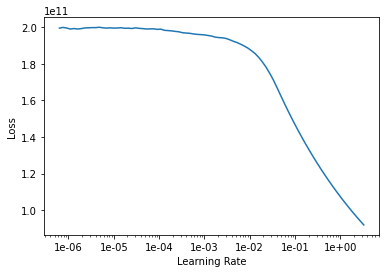

In [26]:
learn.lr_find();
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,root_mean_squared_error,mean_absolute_error,exp_rmspe,weighted_mae,time
0,18.543558,22.928047,4.785751,4.720244,0.989141,18957.810547,01:37
1,7.195367,0.314493,0.534467,0.488116,0.735015,2.871899,01:37
2,2.758921,1.285492,1.133550,1.128724,0.675578,1.654900,01:37
3,1.346378,0.030605,0.173612,0.143428,0.153623,1.049781,01:37
4,1.128387,0.020824,0.142765,0.110711,0.128465,0.824702,01:38


Top score on the leaderboard was wmae=2300 (https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/leaderboard)

My score is wmae=0.82

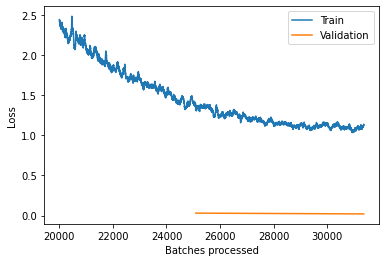

In [38]:
learn.recorder.plot_losses(skip_start=20000)

## Inference

In [283]:
preds, targets= learn.get_preds(DatasetType.Train)
labels = [np.exp(p[0].data.item()) for p in preds]

In [58]:
df_validation['predicted'] = labels

In [284]:
preds

tensor([[9.0894],
        [7.9540],
        [8.2571],
        ...,
        [9.0383],
        [9.7395],
        [9.2516]])

In [285]:
targets

tensor([10.0253,  8.5656,  8.9053,  ...,  9.9301, 10.8802, 10.5530])